<a href="https://colab.research.google.com/github/kanish-dev/neural-nets-learnings/blob/main/Llama_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Llama from scratch (or how to implement a paper)

### **OverView**

In [53]:
print(generate(llama, MASTER_CONFIG, 800)[0])


tDt that wreeds
And mays ceared prartiself for was heaving.

PRISLIET:
And to perforce satcurce: avoiced
Hereling to judge!
And inVillane, which Hermyrangs:
Kile Clifismeness. that say.

Shamh his, as non.

Clown out our cilliking our king pillient my heavens.

ANOTANUS:
If my hew;
Or, tajudatainion stull, that so Them mere.

Nueet pells of their eardain.
Angreator own the ting fly.

QUEEN ELIET:
With him.

KING RICHARD III:
What I had am night.

ServAUS:

KING RICHARD RICHARD III:
Bascome, a havy chese you well for.

MERVEN LAURENCE:
And unto twey come me,
My sword your feir towe'ls eye;
Un, with tUll his doubt's come erlf you, deal squain, sting, abrother things, were prises love:
I that make with it ploviene. Villisijerlanciu, put, like colstage,--
Clugain, in spurition, shows.
You grie


### About Llama
`Llama is a transformer-based model for language modeling. Meta AI open-sourced Llama this summer, and it's gained a lot of attention (pun intended). When you're reading the introduction, they clearly indicate their goal: make a model that's cheaper for running inference, rather than optimizing training costs.`

here using the paper we could reduce the validation loss from `loss:  3.94129273891449 `  to `loss: 0.9353266000747681`

In [5]:
import torch
from  torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

### Setting up our dataset
`While in Llama they train on 1.4T tokens, our dataset TinyShakespeare, the collection of all of Shakespeare's works, is about 1M characters.`

In [55]:
!wget  https://raw.githubusercontent.com/kanish-dev/neural-nets-learnings/main/input.txt

--2023-08-14 18:15:59--  https://raw.githubusercontent.com/kanish-dev/neural-nets-learnings/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-08-14 18:15:59 (16.9 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [6]:
lines = open('input.txt','r').read()

vocab = sorted(list(set(lines)))
len(vocab)

itos = {i:ch for i,ch in enumerate(vocab)}
stoi = {ch:i for i,ch in itos.items()}


print(lines[:30])
len(vocab)

First Citizen:
Before we proce


65

In [7]:
def encode(s):
  return [stoi[ch] for ch in s]

def decode(l):
  return "".join(itos[i] for i in l)

print("Vocab size: ",len(vocab))
decode(encode("hello"))


Vocab size:  65


'hello'

In [8]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [9]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.size(0)

1115394

In [10]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
  train = data[:int(.8 * len(data))]
  val  = data[int(.8 * len(data)) : int(.9 * len(data))]
  test = data[int(.9*len(data)):]

  batch_data = train
  if split == 'val':
    batch_data = val
  if split == 'test':
    batch_data = test

  # pick random starting points
  xi = torch.randint(0,batch_data.size(0) - context_window - 1,(batch_size,))
  x  = torch.stack([batch_data[i:i + context_window] for i in xi ]).long()
  y  = torch.stack([batch_data[i + 1:i + context_window + 1] for i in xi ]).long()
  # print("hi im here",xi)
  return x,y

MASTER_CONFIG.update({
    "batch_size":32,
    "context_window":16
})


xs, ys = get_batches(dataset,"train",MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'] )
# print(xs,"\n",ys)

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('ity but the peop', 'ty but the peopl'),
 ('dy with their he', 'y with their hel'),
 ('e, than tigers o', ', than tigers of'),
 ('ve,\nAnd in the s', 'e,\nAnd in the st'),
 ('shall go.\n\nDUKE ', 'hall go.\n\nDUKE O'),
 ('ul Rome,\nLike a ', 'l Rome,\nLike a b'),
 ('ath not seen the', 'th not seen them'),
 ('am like you, the', 'm like you, they'),
 ('e.\n\nMENENIUS:\nSe', '.\n\nMENENIUS:\nSee'),
 ('hou to a morsel ', 'ou to a morsel o'),
 ('all the watch.\n\n', 'll the watch.\n\nP'),
 ('frame thee. Do y', 'rame thee. Do yo'),
 ('th a free desire', 'h a free desire\n'),
 ('God or fortune c', 'od or fortune ca'),
 ('stance, is King ', 'tance, is King R'),
 (', weapons, weapo', ' weapons, weapon'),
 ('riminal and in s', 'iminal and in su'),
 (',\nThou art their', '\nThou art their '),
 (' the field,\nThat', 'the field,\nThat '),
 ('nce, where we ma', 'ce, where we may'),
 ('wife to the Engl', 'ife to the Engli'),
 (' but mock, besto', 'but mock, bestow'),
 ('old your majesty', 'ld your 

In [11]:
@torch.no_grad()

def evaluate_loss(model, config=MASTER_CONFIG):
  out = {}
  model.eval()
  for split in ["train","val"]:
    losses = []
    for _ in range(10):
      xs, ys = get_batches(dataset, split, MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
      _,loss = model(xs,ys)
      losses.append(loss.item())
    out[split] = np.mean(losses)

  model.train()
  return out


In [12]:
class SimpleBrokenModel(nn.Module):

  def __init__(self, config=MASTER_CONFIG):
    super().__init__()

    self.config = config
    self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
    self.linear = nn.Sequential(
        nn.Linear(config["d_model"],config["d_model"]),
        nn.ReLU(),
        nn.Linear(config["d_model"],config["vocab_size"]),
    )
    print("model parms: ",sum([m.numel() for m in self.parameters()]))

  def forward(self, idx, targets=None):
    x = self.embedding(idx)
    a = self.linear(x)
    logits = F.softmax(a, dim=-1)

    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))

      return logits, loss

    else:
      return logits


MASTER_CONFIG.update({
    "d_model" :128,
})

model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, "train", MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs,ys)

model parms:  33217


In [13]:
# loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))

model parms:  33217
validation loss:  3.94129273891449


<Axes: >

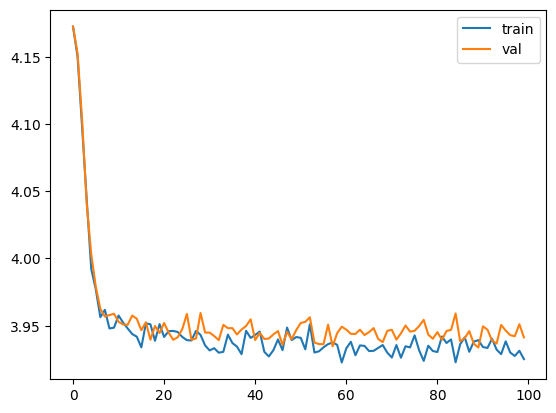

In [14]:
MASTER_CONFIG.update({
    "epochs":1000,
    "log_interval":10
})

model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(),
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
  losses = []
  start_time = time.time()

  for epoch in range(config['epochs']):
    optimizer.zero_grad()
    xs,ys = get_batches(dataset,"train",config["batch_size"],config["context_window"])
    logits, loss = model(xs, targets=ys)
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step()

    if epoch % config['log_interval'] == 0:
      batch_time = time.time() - start_time
      x=evaluate_loss(model)
      losses +=[x]
      if print_logs:
        (f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
      start_time = time.time()

      if scheduler:
        print("lr:",scheduler.get_lr())

  print("validation loss: ", losses[-1]['val'])
  return pd.DataFrame(losses).plot()


train(model, optimizer)


model parms:  33217
validation loss:  2.519991326332092


<Axes: >

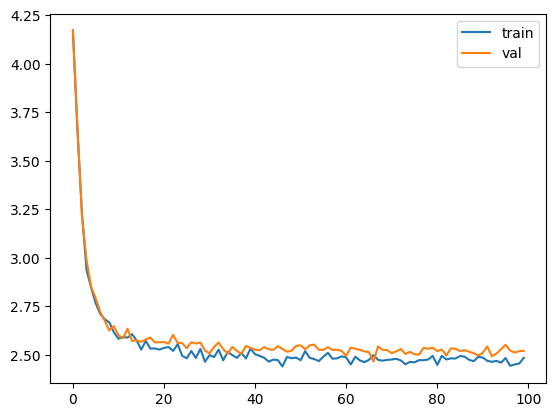

In [15]:
class SimpleModel(nn.Module):

  def __init__(self, config=MASTER_CONFIG):
    super().__init__()

    self.config = config
    self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
    self.linear = nn.Sequential(
        nn.Linear(config["d_model"],config["d_model"]),
        nn.ReLU(),
        nn.Linear(config["d_model"],config["vocab_size"]),
    )
    print("model parms: ",sum([m.numel() for m in self.parameters()]))

  def forward(self, idx, targets=None):
    x = self.embedding(idx)
    logits = self.linear(x)

    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
      return logits, loss

    else:
      return logits


MASTER_CONFIG.update({
    "d_model" :128,
})

model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, "train", MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs,ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [16]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\nThasth havechen te thieaie.\nPf',
 '\nay brd tr ghoghe tess.\n\nWhagr ',
 '\n\nARWhein hedep hrd.\nTha s\nAPim',
 '\nBO,\nSThere teruselorwhes whaba',
 '\nThisthy sitico id n,\nVEDUCAns ']

In [17]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


In [18]:
rms = torch.linalg.norm(batch,dim=(1,2))* batch[0].numel() ** -.5

assert  torch.linalg.norm(torch.arange(5).float()) == (torch.arange(5).float() ** 2).sum() **.5
rms = torch.linalg.norm(torch.arange(5).float()) * (torch.arange(5).numel() ** -.5)

assert torch.allclose(torch.linalg.norm(torch.arange(5).float()/rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch,dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure

ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
  ffx[i] = batch[i]/ff_rms[i]

assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) **2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

model params: 35265
validation loss:  2.5165637969970702


<Axes: >

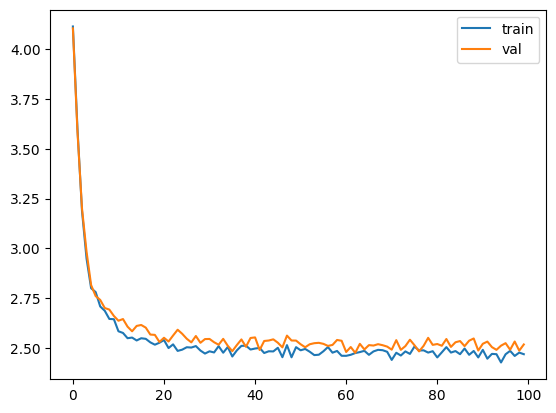

In [19]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [20]:
def get_rotary_matrix(context_window, embedding_dim):
  R = torch.zeros((context_window,embedding_dim,embedding_dim), requires_grad=False)
  for position in range(context_window):
    for i in range (embedding_dim//2):
      theta = 10000. **(-2.*(i-1)/embedding_dim)
      m_theta = theta*position
      R[position, 2*i, 2*i] = np.cos(m_theta)
      R[position, 2*i, 2*i+1] = -np.sin(m_theta)
      R[position, 2*i+1, 2*i] = np.sin(m_theta)
      R[position, 2*i+1, 2*i+1] = np.cos(m_theta)

  return R

In [21]:

plt.show()


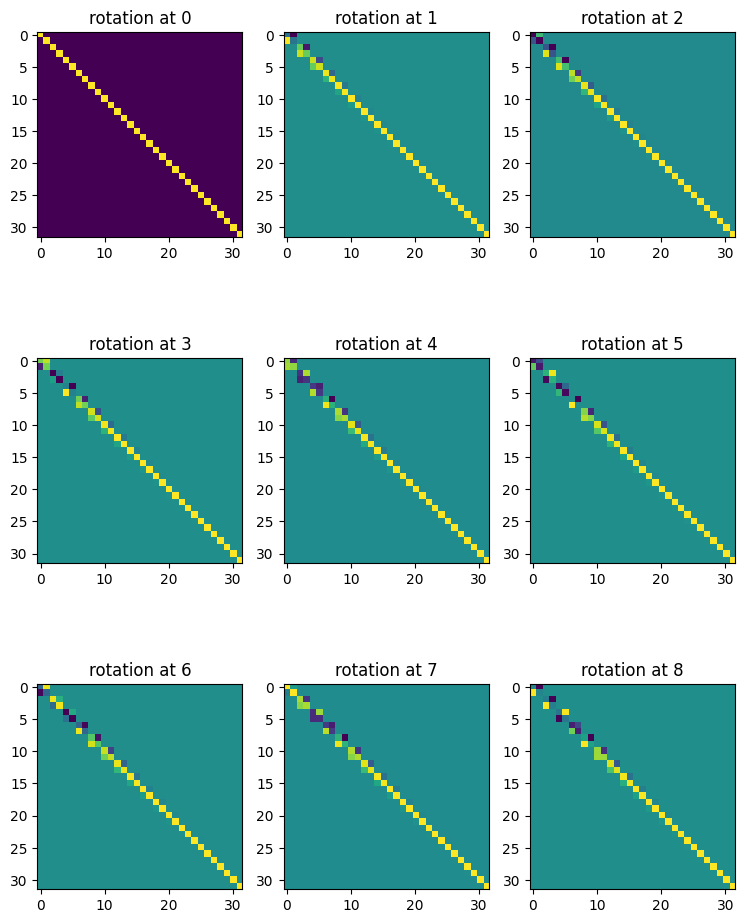

In [22]:
K = 3
config ={
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}

batch = torch.randn(1,config['context_window'],config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K,K, figsize=(K*3, K*4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [23]:
config = {
    "d_model":128,
    "context_window":16
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

In [24]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R)).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R)).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R)).transpose(0,1)

        activations, attn_weights = self.multihead(
            q_out,k_out,v_out,
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)


In [25]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_out = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_out = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_out)

In [26]:
config ={
    "batch_size":1,
    "d_model":2,
    "n_heads":2,
    "context_window":3,
}

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'],config['context_window'],config['d_model']))
output, attn_weights =  layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0,m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0,n]
k = layer.R[n,:,:]@layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

<ipython-input-26-dfcccfb46464>:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  assert q.T @ k == q @ k # transpose is redundant


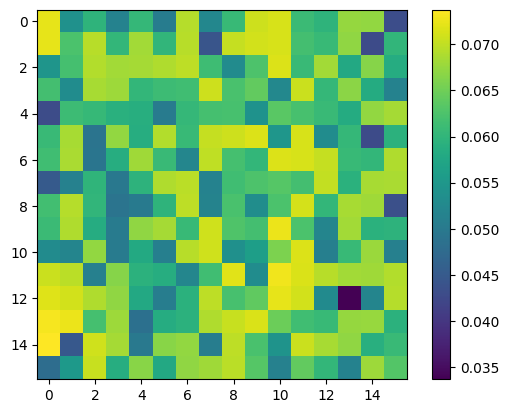

In [27]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()


In [28]:
class RoPEAttention_wMask(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R[:m, ...])).transpose(0,1)

        activations, attn_weights = self.multihead(
            q_out,k_out,v_out,
            attn_mask = nn.Transformer.generate_square_subsequent_mask(m),
            is_causal = False
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

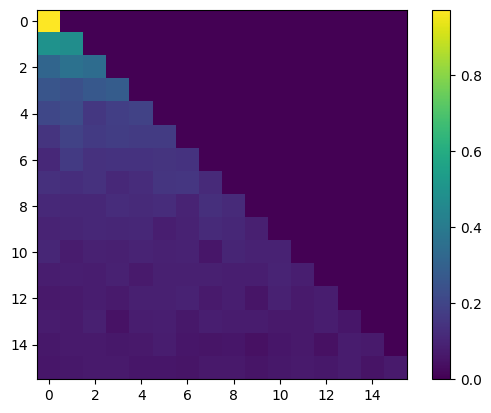

In [29]:
layer = RoPEAttention_wMask(MASTER_CONFIG)
batch = torch.randn((MASTER_CONFIG['batch_size'],MASTER_CONFIG['context_window'],MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)


plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()

model params: 150465
validation loss:  0.15054788887500764


<Axes: >

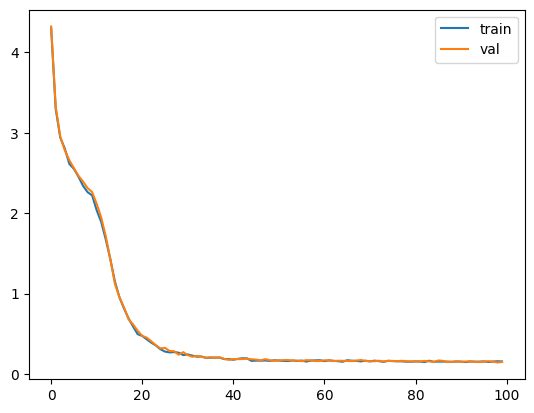

In [30]:
class RoPEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)


        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RoPEModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

validation loss:  0.1390489913523197


<Axes: >

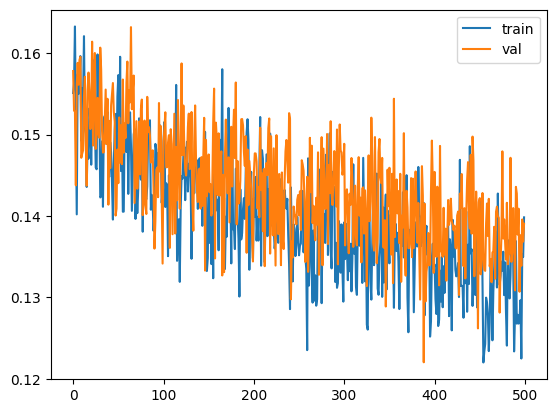

In [31]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer)

In [32]:
evaluate_loss(model)

{'train': 0.1318582735955715, 'val': 0.14212456792593003}

In [33]:
class SwiGLU(nn.Module):
  def __init__(self,size):
    super().__init__()
    self.config = config
    self.linear_gate = nn.Linear(size,size)
    self.linear = nn.Linear(size,size)
    self.beta = torch.randn(1,requires_grad=True)

    self.beta = nn.Parameter(torch.ones(1))
    self.register_parameter('beta',self.beta)


  def forward(self, x):
    swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
    out = swish_gate * self.linear(x)
    return out




model params: 183490
validation loss:  0.1435092106461525


<Axes: >

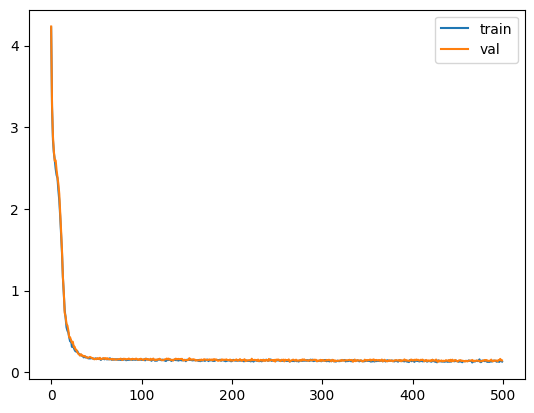

In [34]:
class RoPEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)


        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RoPEModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [35]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEAttention_wMask(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [36]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));

model params: 733382
validation loss:  1.5886143445968628


<Axes: >

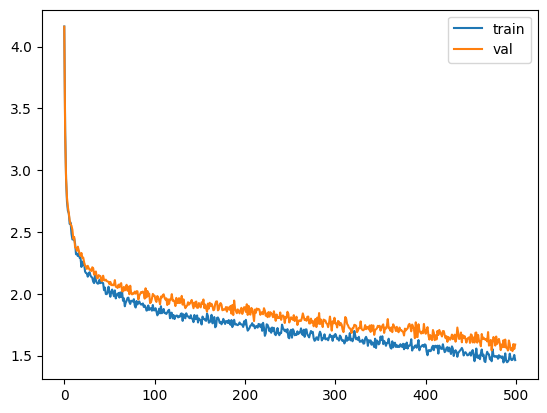

In [37]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

validation loss:  0.9353266000747681


<Axes: >

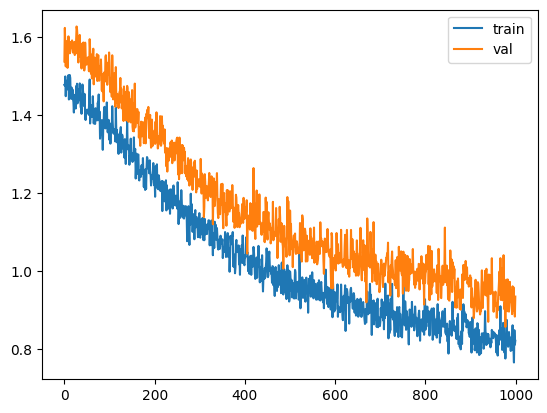

In [38]:
MASTER_CONFIG.update({
    'epochs':10000
})

train(llama,optimizer,scheduler=None,config=MASTER_CONFIG)

In [ ]:
train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)

In [54]:
print(generate(llama, MASTER_CONFIG, 500)[0])


ttet that tillide,--'y

ANURIEL:
Have sand
This pards with on the eadty for odd you, valion, and merfosine's! down, thou thou pinle's?

PRINCE:
What fatch to: ! Wapkard darine, 's my breath, his
There, shalt like of the carrod a king
For was
To loss,
He fress him he had!

Msway's dayon's daning tooos emojeriet; or
With you crusness frrwick strack'd Your once
Perdeashing my yother!

Nusbour lies, 'That I am, scrown teneing his spect.

MERCUS:
Dieod ce.

YORK:
AupHnot! Lorder, woef not heaven plov


In [42]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = llama(xs,ys)
print(loss)

tensor(0.9932, grad_fn=<NllLossBackward0>)


In [44]:
def show_grads(model,tol=1e-2):
  return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.llama_0.attention.multihead.in_proj_bias', 36.197916666666664),
 ('llama_blocks.llama_3.attention.multihead.in_proj_bias', 35.9375),
 ('llama_blocks.llama_1.attention.multihead.in_proj_bias', 35.677083333333336),
 ('llama_blocks.llama_2.attention.multihead.in_proj_bias', 35.416666666666664),
 ('llama_blocks.llama_0.attention.multihead.in_proj_weight', 16.73583984375),
 ('llama_blocks.llama_0.attention.w_q.weight', 12.664794921875),
 ('llama_blocks.llama_0.attention.w_k.weight', 12.255859375),
 ('llama_blocks.llama_0.attention.w_v.weight', 11.669921875),
 ('llama_blocks.llama_1.attention.w_v.weight', 11.65771484375),
 ('llama_blocks.llama_0.attention.multihead.out_proj.weight', 11.492919921875),
 ('llama_blocks.llama_2.attention.multihead.out_proj.weight', 11.456298828125),
 ('llama_blocks.llama_3.attention.multihead.out_proj.weight', 11.26708984375),
 ('llama_blocks.llama_2.attention.w_v.weight', 11.2548828125),
 ('llama_blocks.llama_3.attention.w_v.weight', 10.82763671

EXPERIMENTING

model params: 733382


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr: [0.0009999457184159408]
lr: [0.0009961510274583004]
lr: [0.0009869757772816292]
lr: [0.0009725204933511963]
lr: [0.0009529435502760634]
lr: [0.0009284594366176498]
lr: [0.0008993364049014041]
lr: [0.0008658935325782156]
lr: [0.0008284972261358946]
lr: [0.0007875572066618724]
lr: [0.0007435220208394261]
lr: [0.0006968741265588948]
lr: [0.0006481246069855613]
lr: [0.0005978075709959357]
lr: [0.0005464743013294258]
lr: [0.0004946872145648923]
lr: [0.00044301369909075325]
lr: [0.00039201989856974814]
lr: [0.0003422645089892466]
lr: [0.0002942926572257539]
lr: [0.0002486299281339155]
lr: [0.0002057766054928797]
lr: [0.00016620218969383484]
lr: [0.00013034025177986015]
lr: [9.85836791664324e-05]
lr: [7.128036241775617e-05]
lr: [4.872936226262451e-05]
lr: [3.117756953567661e-05]
lr: [1.8816750064937722e-05]
lr: [1.1779739336260682e-05]
lr: [1.0054282328142978e-05]
lr: [1.396862020283371e-05]
lr: [2.3138198807489664e-05]
lr: [3.7591595433673565e-05]
lr: [5.716757986058714e-05]
lr: [8.16511

<Axes: >

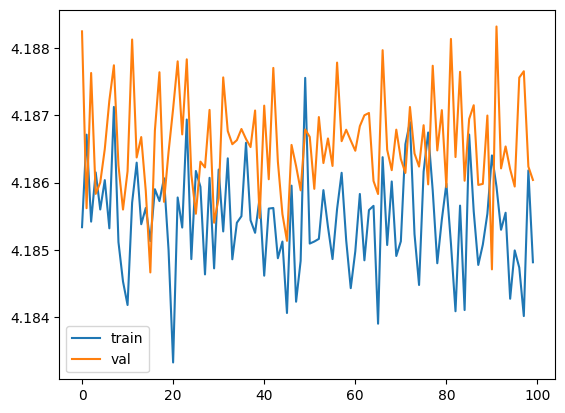

In [47]:
MASTER_CONFIG.update({
    'epochs':1000
})

llama_with_cosine = Llama(MASTER_CONFIG)
llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [48]:
show_grads(llama_with_cosine, 1e-5)


[('llama_blocks.llama_0.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_0.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_1.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_1.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_2.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_2.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_3.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_3.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_3.attention.w_q.weight', 0.030517578125),
 ('llama_blocks.llama_0.attention.w_k.weight', 0.0244140625),
 ('llama_blocks.llama_0.attention.w_v.weight', 0.018310546875),
 ('llama_blocks.llama_0.attention.multihead.out_proj.weight', 0.018310546875),
 ('llama_blocks.llama_0.feedforward.0.weight', 0.018310546875),
 ('llama_blocks.llama_1.attention.multihead.out_proj.weight', 0.018310546875),
 ('llama_blocks.llama_1.feedforward.0.weight', 0